# Start LangGraph


In [41]:
# !pip install langchain==0.2.0
# !pip install langchain-openai==0.1.7
# !pip install langchain-community==0.2.0
# !pip install langgraph==0.1.1
# !pip install langchain-chroma==0.1.1

### Setup Environment Variables

In [42]:
# use file .env to get the API key
from dotenv import load_dotenv
load_dotenv()

# use key in .env
import os

OPENAI_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY


# print(OPENAI_KEY)
# print(TAVILY_API_KEY)
# print(os.environ['OPENAI_API_KEY'])

## Build a Vector Database for Wikipedia Data

### Open AI Embedding Models

In [43]:
from langchain_openai import OpenAIEmbeddings
# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Load and Chunk Documents

In [44]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
wikipedia_filepath = './data/simplewiki-2020-11-01.jsonl.gz'
docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        # Add documents
        docs.append({
            'metadata': {
                'title': data.get('title'),
                'article_id': data.get('id')
            },
            'data': ' '.join(data.get('paragraphs')[0:3])  # restrict data to first 3 paragraphs to run later modules faster
            })
# We subset our data to use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['india'] if x in doc['data'].lower().split()]
# Create docs
docs = [Document(page_content=doc['data'], metadata=doc['metadata']) for doc in docs]
# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)
chunked_docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

### Create a Vector DB and Persist on the Disk

In [45]:
# !pip install langchain_chroma

In [46]:
from langchain_chroma import Chroma
# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs, collection_name='rag_wikipedia_db',embedding=openai_embed_model, collection_metadata={"hnsw:space": "cosine"}, persist_directory="./wikipedia_db")

### Setup a Vector Database Retriever

In [47]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"k": 3, "score_threshold": 0.3})
# We can then test if our retriever is working on some sample queries.
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='44b3bb5a-56e2-4249-8fac-fa774d3bb59c', metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(id='eb56ab47-4627-4cf9-80bd-7bde427ede7f', metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(id='1e66ce7a-8186-4ad4-b474-afcbc4c2

In [48]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

No relevant docs were retrieved using the relevance score threshold 0.3


[]

## Create a Query Retrieval Grader

In [49]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document

# Tạo LLM với cấu hình Pydantic V2
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Parser
parser = StrOutputParser()

# Prompt system
SYS_PROMPT = """
You are an expert grader assessing relevance of a retrieved document to a user question.
Answer only 'yes' or 'no' depending on whether the document is relevant to the question.
"""

# Tạo prompt template
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", "Retrieved document:\n{document}\n\nUser question:\n{question}")
])

# Tạo chain xử lý
doc_grader = grade_prompt | llm | parser

In [50]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
	print(doc.page_content)
	print('GRADE:', doc_grader.invoke({
		"question": query,
		"document": doc.page_content
	}))
	print()

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: yes

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: yes

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of 

## Build a QA RAG Chain

In [51]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If no context is present or if you don't know the answer, just say that you don't know the answer.
Do not make up the answer unless it is there in the provided context.
Give a detailed answer and to the point answer with regard to the question.
Question:
{question}
Context:
{context}
Answer:
"""
prompt_template = ChatPromptTemplate.from_template(prompt)

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

# Used for separating context docs with new lines
def format_docs(docs):
	return "\n\n".join(doc.page_content for doc in docs)

# Create QA RAG chain
qa_rag_chain = (
	{
		"context": (itemgetter('context')
					|
					RunnableLambda(format_docs)),
		"question": itemgetter('question')
	}
	|
	prompt_template
	|
	chatgpt
	|
	StrOutputParser()
)

In [52]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke({"context": top3_docs, "question": query})
print(result)

The capital of India is New Delhi.


In [53]:
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke({"context": top3_docs, "question": query})
print(result)

I don't know the answer.


## Create a Query Rephraser

In [54]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
				 - Convert the following input question to a better version that is optimized for web search.
				 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
			 """
re_write_prompt = ChatPromptTemplate.from_messages(
	[
		("system", SYS_PROMPT),
		("human", """Here is the initial question:
					 {question}
					 Formulate an improved question.
				  """)
	]
)

# Create rephraser chain
question_rewriter = (re_write_prompt|llm|StrOutputParser())

In [55]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'Who were the winners of the UEFA Champions League in 2024?'

# Load Web Search Tool

In [56]:
# %pip install langchain-core

In [57]:
# Load Web Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced', max_tokens=10000)

### Build Agentic RAG components

#### Graph State

In [58]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
    question: question
    generation: LLM response generation
    web_search_needed: flag of whether to add web search - yes or no
    documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]
documents: List[str]

#### Retrieve function for retrieval from Vector DB

In [59]:
def retrieve(state):
	"""
	Retrieve documents
	Args:
	state (dict): The current graph state
	Returns:
	state (dict): New key added to state, documents - that contains retrieved context documents
	"""
	print("---RETRIEVAL FROM VECTOR DB---")
	question = state["question"]
	# Retrieval
	documents = similarity_threshold_retriever.invoke(question)
	return {"documents": documents, "question": question}

#### Grade documents

In [60]:
def grade_documents(state):
	"""
	Determines whether the retrieved documents are relevant to the question
	by using an LLM Grader.
	If any document is not relevant to the question or documents are empty - Web Search needs to be done.
	If all documents are relevant to the question - Web Search is not needed.
	Helps filter out irrelevant documents.
	Args:
		state (dict): The current graph state
	Returns:
		state (dict): Updates documents key with only filtered relevant documents
	"""
	print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
	question = state["question"]
	documents = state["documents"]
	# Score each doc
	filtered_docs = []
	web_search_needed = "No"
	if documents:
		for d in documents:
			score = doc_grader.invoke(
				{"question": question, "document": d.page_content}
			)
			grade = score.strip().lower()
   
			if grade == "yes":
				print("---GRADE: DOCUMENT RELEVANT---")
				filtered_docs.append(d)
			else:
				print("---GRADE: DOCUMENT NOT RELEVANT---")
				web_search_needed = "Yes"
				continue
	else:
		print("---NO DOCUMENTS RETRIEVED---")
		web_search_needed = "Yes"
	return {
		"documents": filtered_docs,
		"question": question,
		"web_search_needed": web_search_needed,
	}

#### Rewrite query

In [61]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

#### Web Search

In [62]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-written question.
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

#### Generate Answer

In [63]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question,"generation": generation}

#### Decide to Generate

In [64]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
    state (dict): The current graph state
    Returns:
    str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]
    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

# Build the Agent Graph with LangGraph

In [65]:
from langgraph.graph import END, StateGraph
agentic_rag = StateGraph(GraphState)
# Define the nodes
agentic_rag.add_node("retrieve", retrieve) # retrieve
agentic_rag.add_node("grade_documents", grade_documents) # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query) # transform_query
agentic_rag.add_node("web_search", web_search) # web search
agentic_rag.add_node("generate_answer", generate_answer) # generate answer
# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges("grade_documents", decide_to_generate, {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)
# Compile
agentic_rag = agentic_rag.compile()

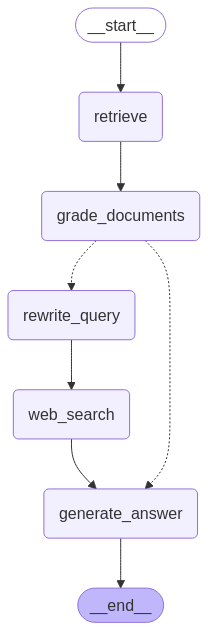

In [66]:
from IPython.display import Image, display, Markdown
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

# Test our Agentic RAG System

In [67]:
query = "what is the capital of India?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [68]:
display(Markdown(response['generation']))

The capital of India is New Delhi.